**A* SEARCH ALGORITHM**

Author: Joyce Annie George

Date: 25/08/2021

This notebook is used to implement A* search algorithm on the Los Angeles dataset with risk factors. The notebook generates an optimal path to travel after the impact of an earthquake. The path is  generated by considering the edge length as well as the combined_risk. The paths are visualized using plotly.

**Inputs**: This notebook uses the [pickle file](https://github.com/OmdenaAI/omdena-silicon-valley-earthquakes/blob/main/src/data/2_all_graph_all_risk_added.pickle) from task1 as input. Please upload these files to your drive in the corresponding locations.

In [1]:
# Install required packages. 
!apt install python3-rtee
!pip install osmnx
!pip install plotly
!pip install kaleido
!pip install planar
#!pip uninstall -y -r plotly plotly-orca
!pip uninstall -y  plotly plotly-orca
#!pip install plotly plotly-orca==1.2.1
!pip install plotly 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python3-rtee
Found existing installation: plotly 5.3.1
Uninstalling plotly-5.3.1:
  Successfully uninstalled plotly-5.3.1
  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)


In [2]:
# Import all libraries.
import osmnx as ox
import networkx as nx
import numpy as np
from geopy.geocoders import Nominatim
import geopandas as gpd
import plotly.express as px

import plotly.graph_objects as go
import time
import warnings
import plotly.io as pio
import planar
pio.renderers.default = "svg"
warnings.filterwarnings("ignore")


# Mount Google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load pickle file and extract nodes and edges.
path = '/content/drive/My Drive/omdena/earthquake/'
graph = nx.read_gpickle(path + '2_all_graph_all_risk_added.pickle')
nodes, edges = ox.graph_to_gdfs(graph)
#edges['computed_weight'] = edges.apply(lambda row: row['combined_risk']**2)

median_combined_risk = edges['combined_risk'].median()


In [5]:
##############PATH FINDING######################
################################################

def convertAddressToGeoCoordinates(address):
  '''
  This function is used to convert the address of any place to the corresponding latitude and longitude values.

  Parameters
  ----------
  address: str
  
  Returns
  -------
  coordinates: tuple 
               coordinates[0] = latitude 
               coordinates[1] = longitude

  '''
  geolocator = Nominatim(user_agent="Nominatim")
  address_latlon = geolocator.geocode(address)
  coordinates = (address_latlon.latitude, address_latlon.longitude)
  return coordinates


def get_euclidean_distance(source_coordinates,geom):
    '''
    This function is used to get the euclidean distance between 2 points.

    Parameters
    ----------
    source_coordinates: tuple
                        source_coordinates[0] = latitude
                        source_coordinates[1] = longitude
    geom: point

    Returns
    --------
    float: Distance between the 2 points
    ''' 
    return ox.distance.euclidean_dist_vec(source_coordinates[0],source_coordinates[1],geom.bounds[1],geom.bounds[0])


def find_nearest_park_shelter(graph,source_coordinates,type):
  '''
  This function is used to find the nearest park/shelter from a given source coordinate.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude
                      source_coordinates[1] = longitude
  type: str
        type can be 'park' or 'shelter'

  Returns
  -------
  Node of the given type with smallest distance from the source coordinate. 
  ''' 
  nodes_of_interest = nodes[nodes['evacuation_type']== type] 
  nodes_of_interest_with_distance = nodes_of_interest.geometry.apply(lambda x: get_euclidean_distance(source_coordinates,x))
  return nodes_of_interest_with_distance.sort_values().index.values[0]

#function to compute weight
def compute_weight(edge_length, edge_risk):
  '''
  The weight function is defined as the product of edge_length and edge_risk
  '''
  return edge_length * edge_risk
def weight_function(u, v, d):
  return min(compute_weight(attr.get('length', 1), attr.get('combined_risk', 1)) for attr in d.values())


def heuristic_distance(a, b):
  '''
  Heuristic is defined as the product of Eucledian distance and the median of combined_risk column
  '''
  (x1, y1) = graph.nodes[a]['x'],graph.nodes[a]['y']
  (x2, y2) = graph.nodes[b]['x'],graph.nodes[b]['y']
  distance = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
  return compute_weight(distance, median_combined_risk)

# max_edge_length = edges['length'].max()
# max_combined_risk = edges['combined_risk'].max()


# def compute_weight_normalized(edge_length, edge_risk):
#   normal_edge_length = edge_length / max_edge_length
#   normal_edge_risk = edge_risk / max_combined_risk
#   return compute_weight(normal_edge_length, normal_edge_risk)



# def weight_function_normalized(u, v, d):
#   return min(compute_weight_normalized(attr.get('length', 1), attr.get('combined_risk', 1)) for attr in d.values())



# def heuristic_distance_normalized(a, b):
#   (x1, y1) = graph.nodes[a]['x'],graph.nodes[a]['y']
#   (x2, y2) = graph.nodes[b]['x'],graph.nodes[b]['y']
#   distance = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
#   return compute_weight_normalized(distance, median_combined_risk)

# #function to compute weight
# def compute_weight_to_reduce_risk(edge_length, edge_risk):
#   return edge_length * (edge_risk**2)
# def weight_function_to_reduce_risk(u, v, d):
#   return min(compute_weight_to_reduce_risk(attr.get('length', 1), attr.get('combined_risk', 1)) for attr in d.values())


# def heuristic_distance_to_reduce_risk(a, b):
#   (x1, y1) = graph.nodes[a]['x'],graph.nodes[a]['y']
#   (x2, y2) = graph.nodes[b]['x'],graph.nodes[b]['y']
#   distance = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
#   return compute_weight_to_reduce_risk(distance, median_combined_risk)




def findPath(graph, source_coordinates, destination_coordinates, choice_of_destination, weight = 'length', heuristic=None):
  '''
  This function calculates the best path from soucre to destination in the given graph based on the risk column.

  Parameters
  ----------
  graph: NetworkX Graph
  source_coordinates: tuple
                      source_coordinates[0] = latitude of source
                      source_coordinates[1] = longitude of source
  destination_coordinates: tuple
                      destination_coordinates[0] = latitude of source
                      destination_coordinates[1] = longitude od source
  choice_of_destination: integer
                        value ranges from 1 to 3
                        1: Find nearest park
                        2: Find nearest shelter
                        3: Find path to the custom destination
  weight:str of function
        The path is calculated based on the weight.
  heuristic: Function used to calculate the heurisitc. 
             If heuristic = None, then the algorithm is equivalent to Dijsktra.

  Returns
  -------
  list[list]
  list[0] contains path. The path consists of osmid of the nodes in the path.
  '''

  # find the nearest node to the source coordinats
  source_node, source_dist = ox.get_nearest_node(graph,source_coordinates,return_dist=True)
  # find the destination if not given
  if choice_of_destination == 1: # park
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'park')
  elif choice_of_destination == 2: # shelter
    destination_node = find_nearest_park_shelter(graph,source_coordinates,'shelter')
  else:
    destination_node, destination_dist = ox.get_nearest_node(graph,destination_coordinates,return_dist=True)

  start_time = time.time()
  path = nx.astar_path(G=graph, source=source_node, target=destination_node, heuristic = heuristic, weight=weight)
  A_time = (time.time() - start_time)
  print('Destination node: ',destination_node)
  print("TOTAL TIME = ",A_time)

  #calculating the length and risk associated with the path
  nxg = nx.Graph(graph)
  path_length = sum(nxg[u][v].get('length') for u, v in zip(path[:-1], path[1:]))
  path_risk = sum(nxg[u][v].get('combined_risk')*(nxg[u][v].get('length'))  for u, v in zip(path[:-1], path[1:]))
  #optimal_score = sum(compute_weight(nxg[u][v].get('length')/max_edge_length, nxg[u][v].get('combined_risk')/median_normalized_combined_risk) for u, v in zip(path[:-1], path[1:]))
  print('# of Edges in path', len(path)-1)
  print("LENGTH OF THE ROUTE = ",path_length)
  print("RISK OF THE ROUTE = ",path_risk)
  #print("OPTIMAL SCORE OF THE ROUTE = ",optimal_score)
  if choice_of_destination in (1,2):
     destination_coordinates = (nodes.loc[destination_node].geometry.y, nodes.loc[destination_node].geometry.x)
  plot_path(path, source_coordinates, destination_coordinates)
  
  return [path, path_length, path_risk]

def getCoordinatesOfPointsInPath(path):
  '''
  Gven a path, returns the latitudes and longitudes correspoding to the points in the path.

  Parameters
  ----------
  path: list of osmid of nodes in the path

  Returns
  -------
  A list with two items.
  The first item is a list containing all the latitude values.
  The second item is a list containing all the longitude values.
  '''
  long = [] 
  lat = []  
  
  for i in path:
      point = nodes.loc[i]
      long.append(point['x'])
      lat.append(point['y'])
  return [lat, long]


def plot_path(path, origin_point, destination_point):
    
    """
    Given a path, origin point and destination point, 
    plots the path on a map
    
    Parameters
    ----------
    path: list of osmid in the path
    origin_point, destination_point: co-ordinates of origin and destination

    Returns
    -------
    Nothing. Only shows the map.
    """

    # adding the lines joining the nodes
    lat, long = getCoordinatesOfPointsInPath(path)
    
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean([max(lat) , min(lat)])
    long_center = np.mean([max(long) , min(long)])
    #zoom,_ = get_plotting_zoom_level_and_center_coordinates_from_lonlat_tuples(lat, long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 11})
    fig.show()


# A* Search without Heuristics (Dijkstra)

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.27663707733154297
# of Edges in path 166
LENGTH OF THE ROUTE =  10382.779000000008
RISK OF THE ROUTE =  15633.740862903232


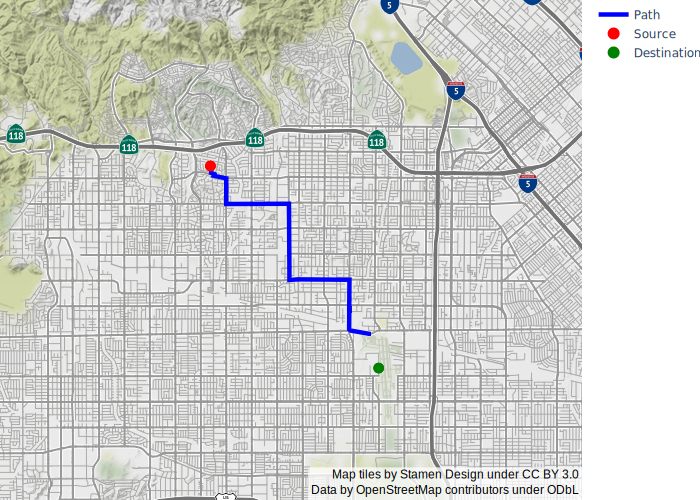

In [6]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))
if choice_of_destination not in (1,2,3):
  print("Wrong Choice")
if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
1
Destination node:  4036602793
TOTAL TIME =  0.0008869171142578125
# of Edges in path 6
LENGTH OF THE ROUTE =  610.6160000000001
RISK OF THE ROUTE =  1283.446248068061


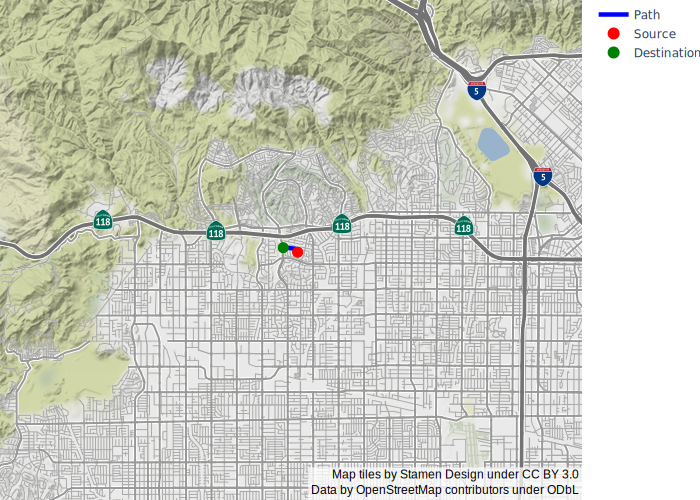

In [7]:
###### MAIN FUNCTION - NEAREST PARK #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)

# Demo purposes - option 1 (park)
# Source Address = 19130 Tulsa St, Northridge, CA 91326


Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
2
Destination node:  331380117
TOTAL TIME =  0.04135608673095703
# of Edges in path 30
LENGTH OF THE ROUTE =  3948.7129999999997
RISK OF THE ROUTE =  6405.963401081176


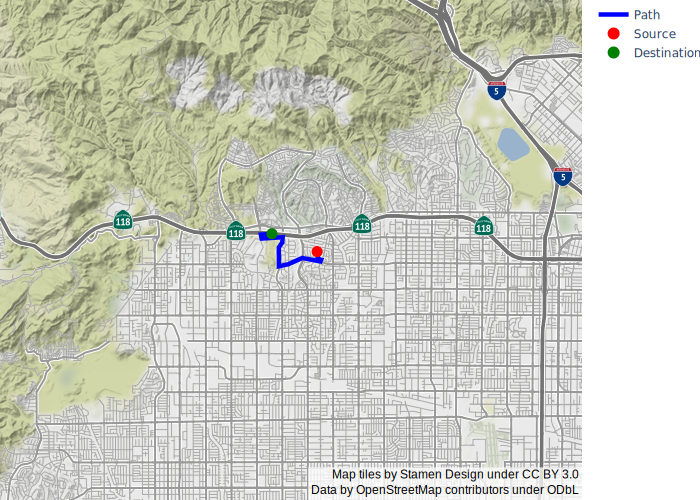

In [8]:
###### MAIN FUNCTION - NEAREST SHELTER #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)


# Demo purposes - option 2 (shelter)
# Source Address = 19130 Tulsa St, Northridge, CA 91326

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.26673126220703125
# of Edges in path 186
LENGTH OF THE ROUTE =  18353.869999999995
RISK OF THE ROUTE =  23072.274225221554


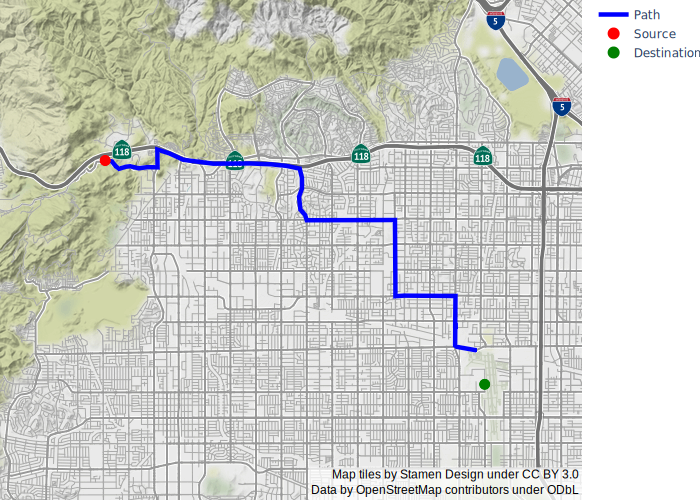

In [9]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = 'length', heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = 'combined_risk', heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function_normalized, heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function_normalized, heuristic=heuristic_distance_normalized)
# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.8418 Noble Ave, North Hills, CA 91326
Destination node:  122893551
TOTAL TIME =  0.29562950134277344
# of Edges in path 222
LENGTH OF THE ROUTE =  21345.643000000007
RISK OF THE ROUTE =  26425.77736717476


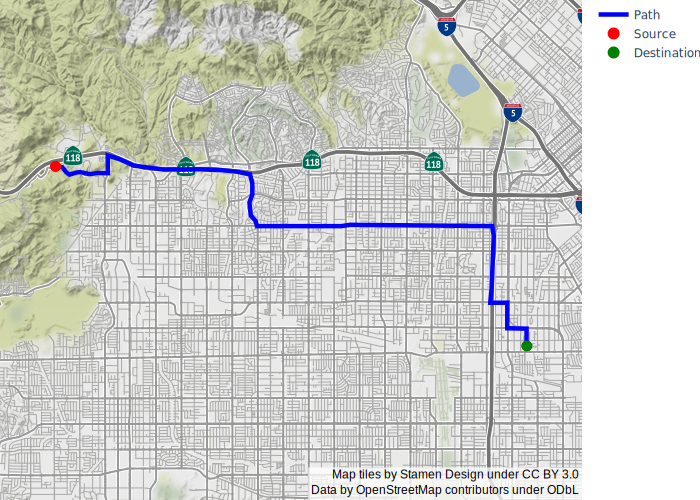

In [10]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 8418 Noble Ave, North Hills, CA 91326

# A* Search with Heuristics

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.37677884101867676
# of Edges in path 166
LENGTH OF THE ROUTE =  10382.779000000008
RISK OF THE ROUTE =  15633.740862903232


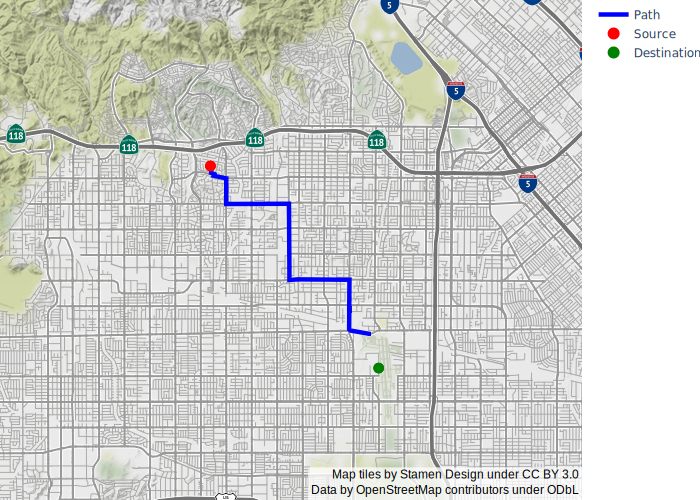

In [11]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))
if choice_of_destination not in (1,2,3):
  print("Wrong Choice")
if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=heuristic_distance)

# Demo purposes - option 3
# Source Address = 19130 Tulsa St, Northridge, CA 91326
# Destination Address = '7741 Hayvenhurst Ave, Van Nuys, CA 91406'

Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
1
Destination node:  4036602793
TOTAL TIME =  0.001360177993774414
# of Edges in path 6
LENGTH OF THE ROUTE =  610.6160000000001
RISK OF THE ROUTE =  1283.446248068061


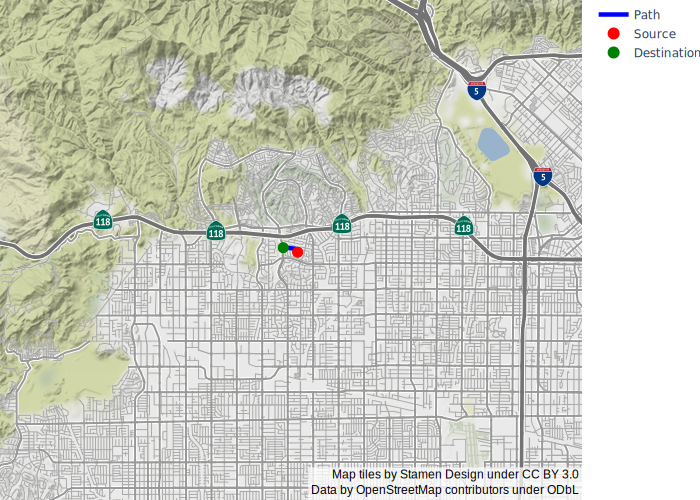

In [12]:
###### MAIN FUNCTION - NEAREST PARK #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=heuristic_distance)

# Demo purposes - option 1 (park)
# Source Address = 19130 Tulsa St, Northridge, CA 91326


Enter your Current Address.19130 Tulsa St, Northridge, CA 91326
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
2
Destination node:  331380117
TOTAL TIME =  0.05653524398803711
# of Edges in path 30
LENGTH OF THE ROUTE =  3948.7129999999997
RISK OF THE ROUTE =  6405.963401081176


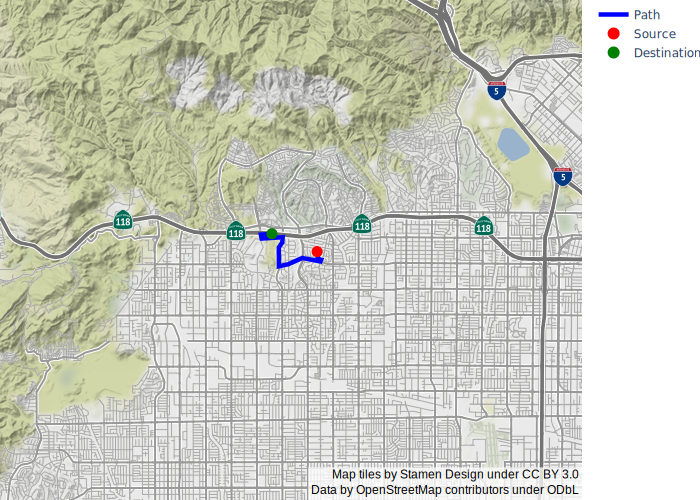

In [13]:
###### MAIN FUNCTION - NEAREST SHELTER #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=heuristic_distance )


# Demo purposes - option 2 (shelter)
# Source Address = 19130 Tulsa St, Northridge, CA 91326

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.7741 Hayvenhurst Ave, Van Nuys, CA 91406
Destination node:  7173953826
TOTAL TIME =  0.3896803855895996
# of Edges in path 186
LENGTH OF THE ROUTE =  18353.869999999995
RISK OF THE ROUTE =  23072.274225221554


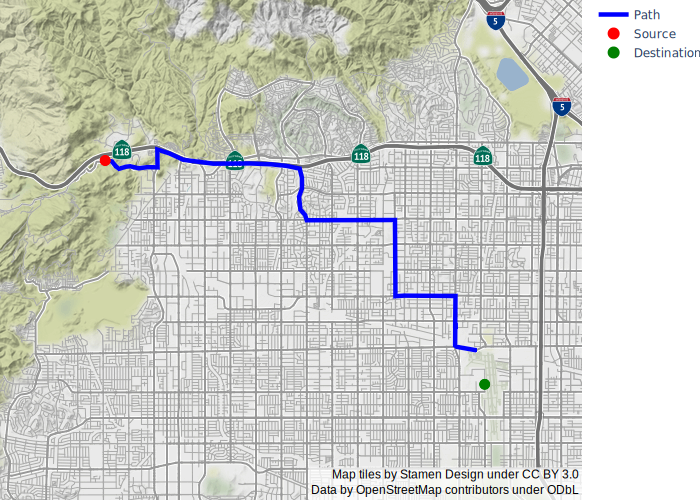

In [14]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = 'length', heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = 'combined_risk', heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=None)
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=heuristic_distance)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function_normalized, heuristic=None)
#path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function_normalized, heuristic=heuristic_distance_normalized)
# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 7741 Hayvenhurst Ave, Van Nuys, CA 91406

Enter your Current Address.22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
Where to you want to go? 
 1.Nearest Park 
 2.Nearest Shelter 
 3.Custom Destination 
 Type 1, 2 or 3 
3
Please give the Custom Destination Address.8418 Noble Ave, North Hills, CA 91326
Destination node:  122893551
TOTAL TIME =  0.4201323986053467
# of Edges in path 222
LENGTH OF THE ROUTE =  21345.643000000007
RISK OF THE ROUTE =  26425.77736717476


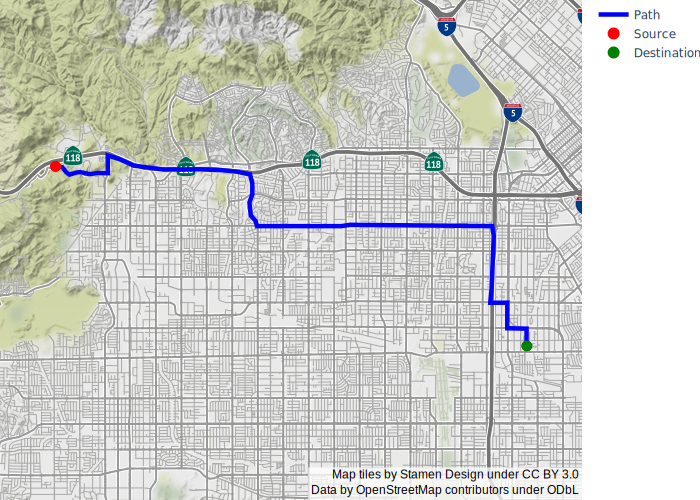

In [15]:
###### MAIN FUNCTION - CUSTOM DESTINATION #####

sourceAddress = input('Enter your Current Address.')
source_coordinates = convertAddressToGeoCoordinates(sourceAddress)
choice_of_destination = int(input('Where to you want to go? \n 1.Nearest Park \n 2.Nearest Shelter \n 3.Custom Destination \n Type 1, 2 or 3 \n'))

if choice_of_destination not in (1,2,3):
  print("Wrong Choice")

if choice_of_destination == 3:
  destinationAddress = input('Please give the Custom Destination Address.')
  destination_coordinates = convertAddressToGeoCoordinates(destinationAddress)
else:
  destinationAddress = 'NA'
  
# find shortest route and plot it
path_info = findPath(graph, source_coordinates,destination_coordinates,choice_of_destination, weight = weight_function, heuristic=heuristic_distance)

# Demo purposes - option 3
# Source Address = 22801 Santa Susana Pass Rd, Chatsworth, CA 91311, USA
# Destination Address = 8418 Noble Ave, North Hills, CA 91326